# Aperture photometry
In this tutorial is a rudimentary introduction to using the [Photutils](https://photutils.readthedocs.io/en/stable/index.html) to perform aperture photometry.

Before you can use Photutils you will need to download the package. If you are using the Anaconda distribution of Python you can install Photutils using using the [conda-forge Anaconda channel](https://anaconda.org/conda-forge/photutils), run:
```
conda install -c conda-forge photutils
```
If you are using a different Python distribution, see the [Photoutils Installation page](https://photutils.readthedocs.io/en/stable/install.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
plt.style.use('~/lib/python/im_disp.mplstyle') 

In [2]:
hdu_list = fits.open('images/stars10_p.fits')
hdu_list.info()

Filename: images/stars10_p.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float64   


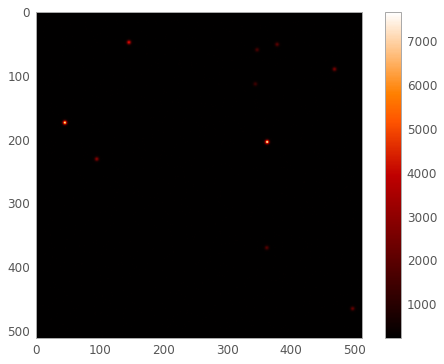

In [3]:
imheader = hdu_list[0].header
imdata = hdu_list[0].data
hdu_list.close()
plt.imshow(imdata)
plt.colorbar()

In [4]:
imheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
OBJECT  = '10 stars'                                                            
EXPTIME =                   60                                                  
GAIN    =                  2.6                                                  

In [5]:
back = np.median(imdata)
print(back)

275.0
